In [44]:
%config Completer.use_jedi = False

In [45]:
import os

synthetic_datasets = os.listdir('../datasets/sklearn-datasets')
real_datasets = os.listdir('../datasets/real-datasets')

In [46]:
datasets_dictionary = dict()
for f in synthetic_datasets:
    try:
        df = pd.read_csv(f'../datasets/sklearn-datasets/{f}')
        target_columns = [col for col in df.columns if col.startswith('target')]
        datasets_dictionary[f] = (df, target_columns)
    except:
        pass

for f in real_datasets:
    try:
        df = pd.read_csv(f'../datasets/real-datasets/{f}').drop(columns = ['instances'])
        target_columns = [col for col in df.columns if col.startswith('algo')]
        datasets_dictionary[f] = (df, target_columns)
    except:
        pass

In [47]:
import logging
import warnings
from dataclasses import dataclass
from typing import Tuple

import seaborn as sns
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist

import time

from scipy.linalg import eig
from scipy.optimize import fmin_bfgs
from scipy.spatial.distance import pdist


_required_opts = ['analytic', 'ntries']
_logger = logging.getLogger(__name__)


@dataclass
class OptimizationOutput:
    A: np.ndarray
    B: np.ndarray
    C: np.ndarray
    Z: np.ndarray
    error: float
    execution_time: float
    n_tries: int
    search_space: float
    method_name: str


def errorfcn(alpha, Xbar, n, m):
    f1 = np.reshape(alpha[(2 * n):], (m, 2))
    f2 = np.reshape(alpha[0:2 * n], (2, n))
    f3 = Xbar[:, 0:n].T
    r = (Xbar - np.dot(f1, np.dot(f2, f3)).T) ** 2
    return np.nanmean(np.nanmean(r, axis=0))

def pilot(X, Y, featlabels=None, **kwargs):
    for opt in _required_opts:
        if opt not in kwargs:
            raise KeyError(f"Pilot required parameter {repr(opt)} missing.")

    Xbar = np.hstack((X, Y))
    n = X.shape[1]
    m = Xbar.shape[1]

    if kwargs['analytic']:
        _logger.info("PILOT is solving analyticaly the projection problem.")
        X = X.T
        Xbar = Xbar.T

        D, V = eig(np.dot(Xbar, Xbar.T), right=True, left=False)

        idx = np.argsort(np.abs(D))[::-1]
        V = V[:, idx[0:2]]
        B = V[0:n, :]
        C = V[n:m + 1, :].T
        Xr = np.dot(X.T, np.linalg.pinv(np.dot(X, X.T)))
        A = np.dot(V.T, np.dot(Xbar, Xr))
        Z = np.dot(A, X)
        Xhat = np.vstack((np.dot(B, Z), np.dot(C.T, Z)))
        error = float(np.sum((Xbar - Xhat) ** 2))
        R2 = np.diagonal(np.corrcoef(Xbar, Xhat, rowvar=False)[:m, m:]) ** 2
        Z = Z.T
    else:
        _logger.info("PILOT is solving numerically the projection problem.")
        ntries = kwargs['ntries']
        seed = kwargs['seed'] if 'seed' in kwargs else 1
        np.random.seed(seed)
        X0 = 2 * np.random.random((ntries, 2 * m + 2 * n)).T - 1
        alpha = np.zeros((2 * m + 2 * n, ntries))
        eoptim = np.zeros(ntries)
        perf = np.zeros(ntries)
        Hd = pdist(X)[np.newaxis].T
        
        start_time = time.time()
        for i in range(ntries):
            alpha[:, i], eoptim[i] = fmin_bfgs(lambda a: errorfcn(a, Xbar, n, m), x0=X0[:, i],
                                               full_output=True, disp=False)[:2]
#             print('shape alpha', alpha.shape, "alpha\n", alpha)
            aux = alpha[:, [i]]
            A = np.reshape(aux[0:2 * n], (2, n))
            Z = np.dot(X, A.T)
            perf[i] = np.corrcoef(Hd, pdist(Z)[np.newaxis].T, rowvar=False)[0][1]
            _logger.info(f"PILOT has completed trial {i+1}")
        
        end_time = time.time()
        
        idx = np.argmax(perf)
        A = np.reshape(alpha[0:2 * n, idx], (2, n))
        Z = np.dot(X, A.T)
        B = np.reshape(alpha[(2 * n):, idx], (m, 2))
        Xhat = np.dot(Z, B.T)
        C = B[n:m + 1, :].T
        B = B[0:n + 1, :]
        error = np.sum((Xbar - Xhat) ** 2)
        execution_time = end_time - start_time
        with warnings.catch_warnings(record=True) as w:
            R2 = np.diagonal(np.corrcoef(Xbar, Xhat, rowvar=False)[:m, m:]) ** 2

    out = OptimizationOutput(A, B, C, Z, error, execution_time, ntries, 0, 'bfgs')
    _logger.info("PILOT has completed.")
    return out


def adjust_rotation(Z: np.ndarray, Ybad: np.ndarray, theta: float = 135.0) -> Tuple[np.ndarray, np.ndarray]:
    cenroid_bad = np.mean(Z[Ybad], axis=0)[::-1]
    theta = np.radians(theta) - np.arctan2(*cenroid_bad)
    rot = np.array(((np.cos(theta), -np.sin(theta)),
                    (np.sin(theta), np.cos(theta))))
    Z_rot = np.dot(rot, Z.T)
    return Z_rot.T, rot


In [48]:
from experimentation import run_optimization

In [49]:
%%time
ntries = 30
experiments = dict()
for filename, item in datasets_dictionary.items():
    experiments[filename] = run_optimization(df = item[0], 
                                             target_columns = item[1], 
                                             optimization_method = pilot,
                                             ntries = ntries,
                                             analytic = False
                                            )

CPU times: user 12min 14s, sys: 11.5 s, total: 12min 26s
Wall time: 7min 32s


In [50]:
def plot_scatter_plot(x, y, title = None, x_label = None, y_label = None, hue_data = None):    
    
    fig, ax = plt.subplots(figsize = (10, 8))
    n_colors = len(hue_data.unique())
    sns.scatterplot(x = x, y = y, hue = hue_data, palette = sns.color_palette("vlag", n_colors), legend = False)
    ax.set_title(title)
    sns.despine()

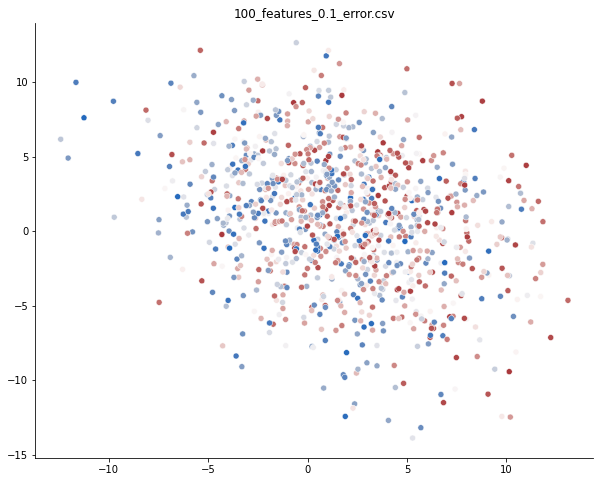

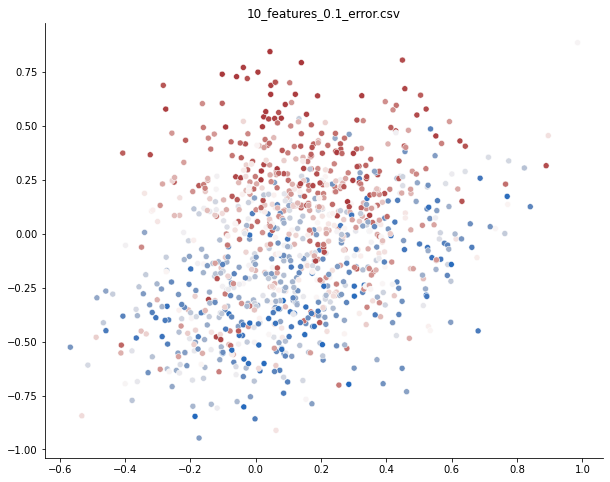

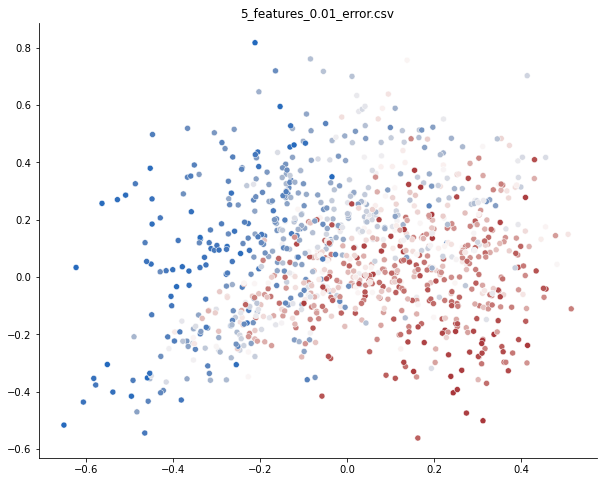

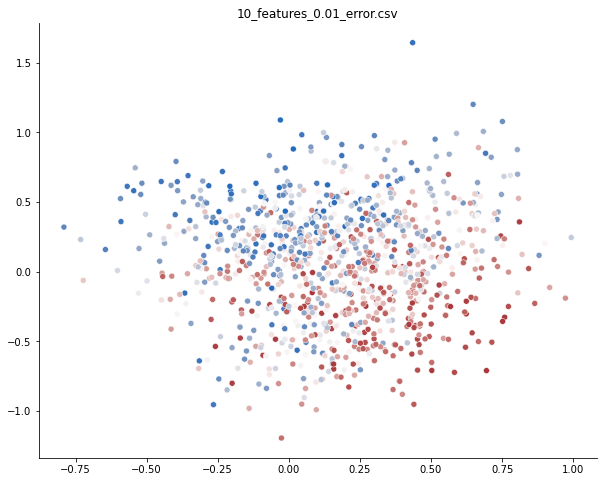

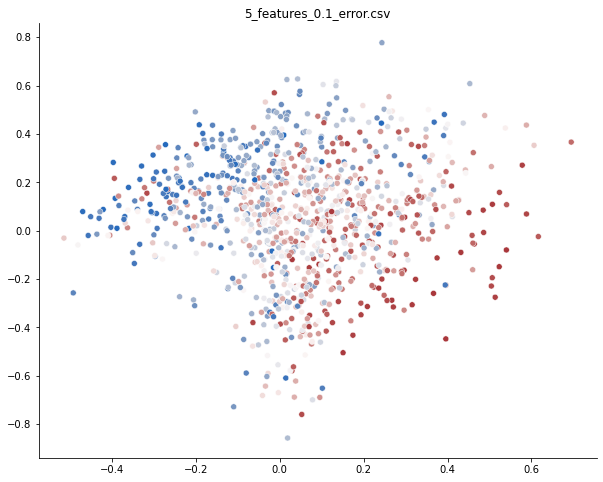

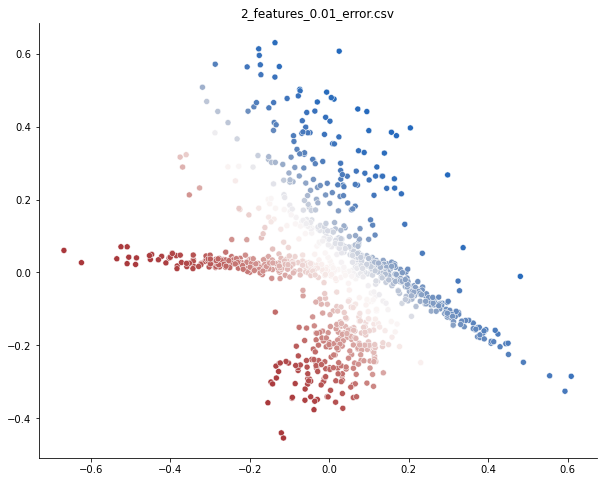

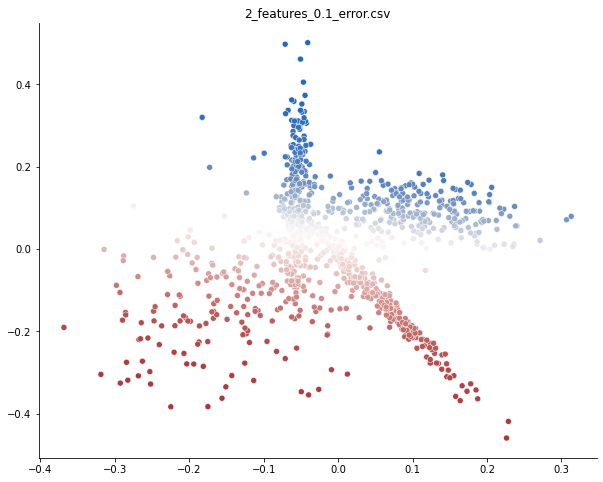

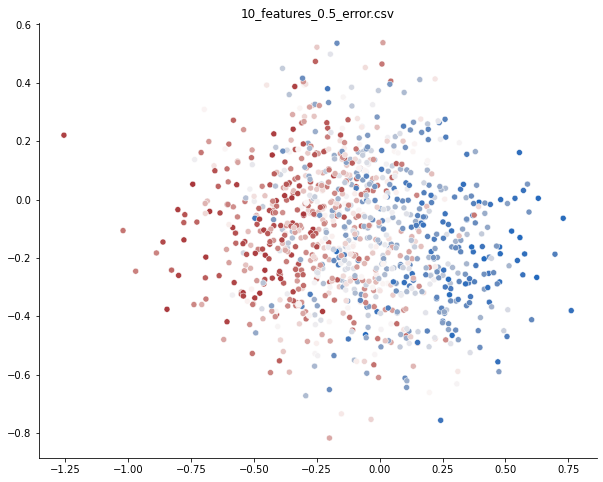

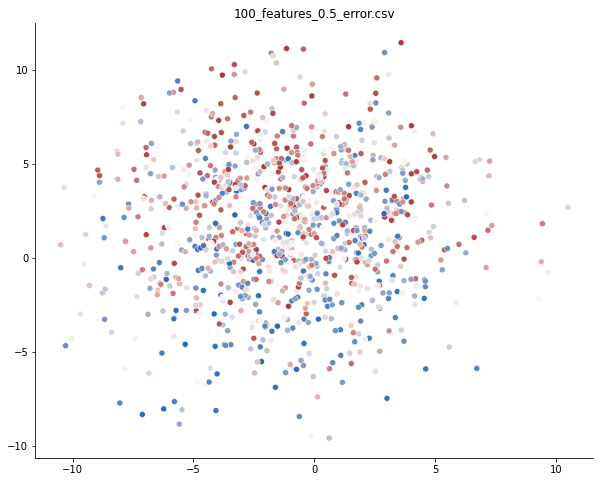

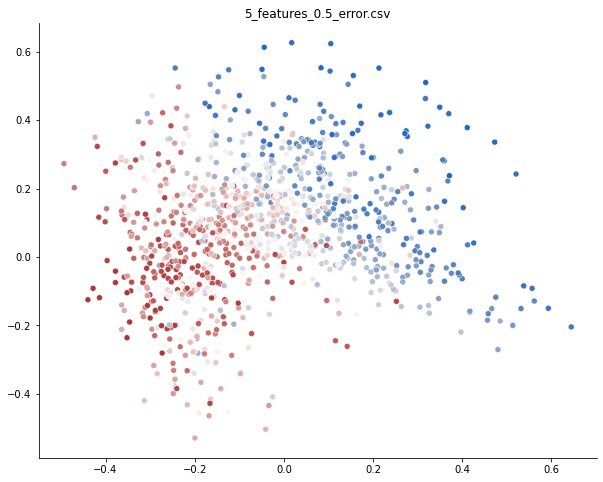

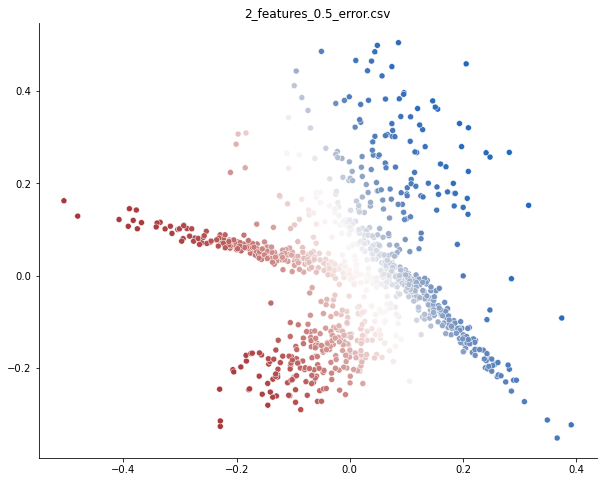

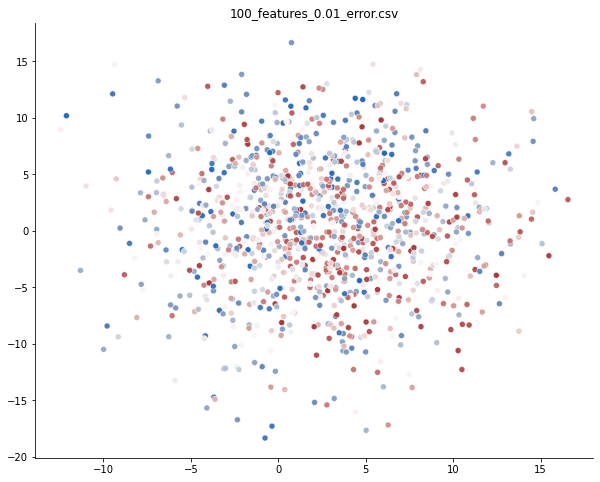

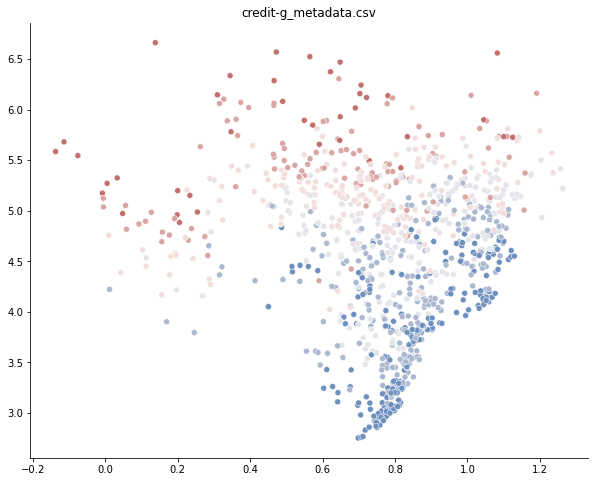

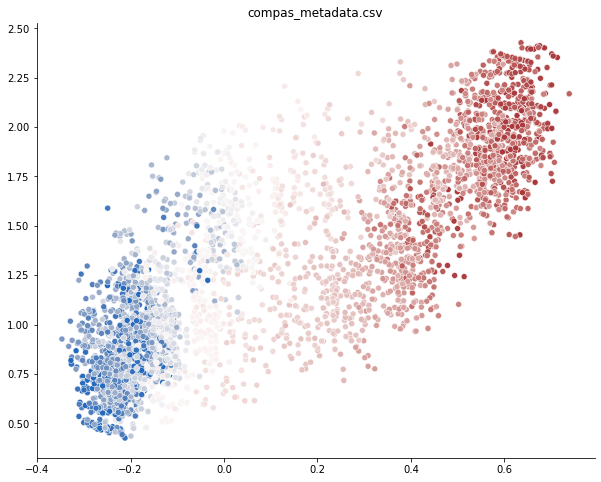

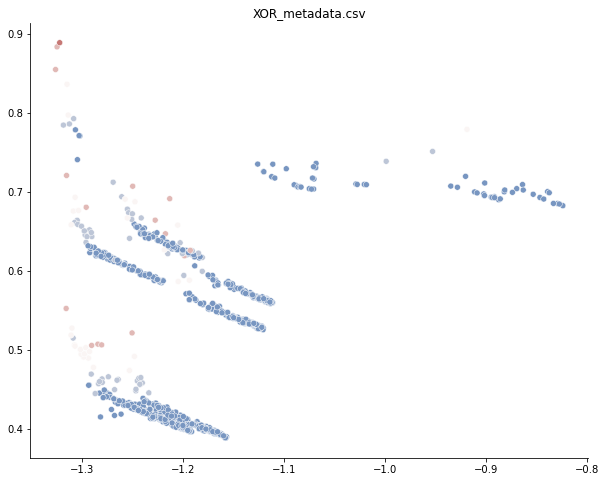

In [51]:
for dataset_filename in experiments.keys():
    instance_hardness_metric = datasets_dictionary[dataset_filename][0].iloc[:, 0]
    plot_scatter_plot(x = experiments[dataset_filename].Z[:,0],
                      y = experiments[dataset_filename].Z[:,1],
                      hue_data = instance_hardness_metric,
                      title = dataset_filename)

In [52]:
from experimentation import create_results_dataframe

bfgs_results_df = create_results_dataframe(experiments)
bfgs_results_df

,dataset,error,execution_time,method,n_tries,search_space
0,100_features_0.1_error.csv,33327.102345,123.049636,bfgs,2,0
1,10_features_0.1_error.csv,592.473628,3.080980,bfgs,2,0
2,5_features_0.01_error.csv,456.286376,3.018043,bfgs,2,0
3,10_features_0.01_error.csv,570.333949,8.204015,bfgs,2,0
4,5_features_0.1_error.csv,458.599031,1.368697,bfgs,2,0
5,2_features_0.01_error.csv,375.363799,0.443833,bfgs,2,0
6,2_features_0.1_error.csv,393.510080,0.337162,bfgs,2,0
7,10_features_0.5_error.csv,667.699899,4.222123,bfgs,2,0
8,100_features_0.5_error.csv,33372.089660,101.072512,bfgs,2,0
9,5_features_0.5_error.csv,450.669358,0.712914,bfgs,2,0


In [55]:
bfgs_results_df.to_excel(f'../results/bfgs-ntries{ntries}.xlsx')